In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from theta.rtbm import RTBM
import numpy as np
import copy
from cma import CMAEvolutionStrategy
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
%matplotlib inline
plt.rcParams['figure.figsize'] = [16, 4]

In [3]:
ndim = 1
nhid = 2
nevt = 1e4
rtbm = RTBM(ndim, nhid, 
            minimization_bound=50,
            gaussian_init=True,
            positive_T=True, 
            positive_Q=True,
            gaussian_parameters = {"mean" : 0.5, "std": 0.1},
            sampling_activation = None
           )
params_0 = copy.deepcopy(rtbm.get_parameters())

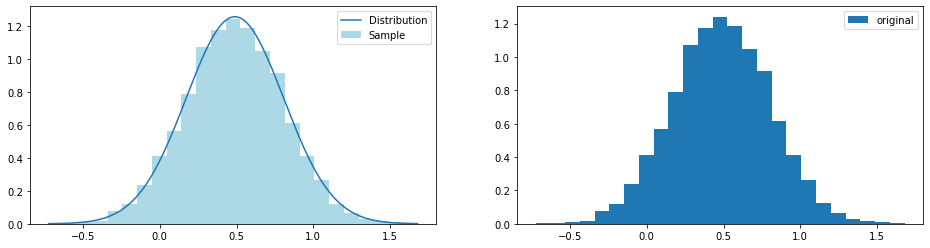

In [4]:
d = 0

def get_values():
    xrand, xjac, original_r = rtbm.make_sample_rho(nevt)

    x = []
    y = []
    ordered_r = []
    for i, j, k in sorted(zip(xrand[:,d], xjac, original_r)):
        x.append(i)
        y.append(j)
        ordered_r.append(k)

    x = np.array(x)
    y = np.array(y)
    ordered_r = np.array(ordered_r)
    return xrand, original_r, x, y, ordered_r

xrand, original_r, x, y, ordered_r = get_values()
        
plt.subplot(1,2,1)
plt.hist(xrand[:,d], bins=25, density=True, color="lightblue", label="Sample")
plt.plot(x, y, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(original_r[:,d], bins=25, density=True, label="original")
_ = plt.legend()

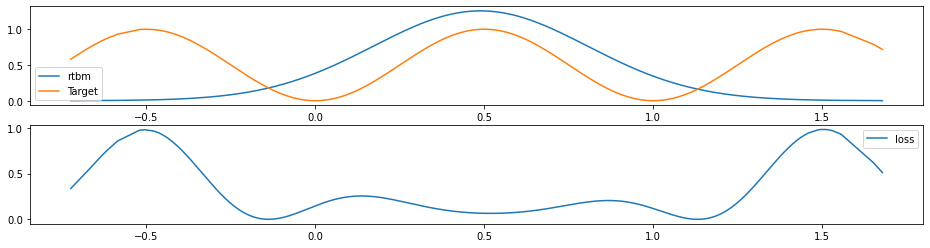

In [5]:
def my_fun(xarr):
    res = pow(np.sin(xarr*np.pi*1.0), 2)
    return res

def kl(x, y):
    return -(y*np.log(x+1e-8))

def mse(x, y):
    return (x-y)**2

loss = mse


my_y = my_fun(x)
_, y_rtbm = rtbm.get_transformation(ordered_r)
ll = loss(my_y, y_rtbm)

plt.subplot(2,1,1)
plt.plot(x, y_rtbm, label="rtbm")
plt.plot(x, my_y, label = "Target")
_ = plt.legend()
plt.subplot(2,1,2)
plt.plot(x, ll, label="loss")
_ = plt.legend()

In [6]:
bounds = rtbm.get_bounds()
options = {
    "bounds": bounds,
    "maxiter": 80,
    "tolfun": 1e-4,
    "popsize": 120,
    "verbose": 0,
}
sigma = np.max(bounds[1])*0.1
es = CMAEvolutionStrategy(params_0, sigma, options)

def target_loss(params):
    if not rtbm.set_parameters(params):
        return np.NaN
        #import ipdb; ipdb.set_trace()
    _, prob = rtbm.get_transformation(ordered_r)
    return np.sum(loss(prob, my_y))

with Parallel(n_jobs=4) as parallel:
    while not es.stop():
        mutants = es.ask(es.popsize)
        # Parallelize this
        # losses = [target_loss(i) for i in mutants]
        parallel_runs = [delayed(target_loss)(i) for i in mutants]
        losses = parallel(parallel_runs)
        worst = np.nanmax(losses)
        if np.isnan(worst):
            continue
        losses = [2.0*worst if np.isnan(x) else x for x in losses]
        es.tell(mutants, losses)
        es.disp()
        
_ = rtbm.set_parameters(es.result.xbest)
best_parameters = copy.deepcopy(rtbm.get_parameters())
# 4 cores, (50, 80), 1:09 min
# 1 core, (50, 80), 4:49 min

(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=930627, Wed Mar  3 09:10:11 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 2.360115826290576e+03 1.0e+00 5.21e+00  5e+00  6e+00 0:02.9
    2    240 1.799134370235674e+03 1.4e+00 5.87e+00  5e+00  6e+00 0:05.2
    3    360 3.052380382303050e+03 1.6e+00 6.94e+00  6e+00  8e+00 0:07.2
    5    600 8.315257086436520e+02 1.8e+00 7.43e+00  6e+00  8e+00 0:11.4
    8    960 9.851232131494025e+02 2.6e+00 6.79e+00  4e+00  8e+00 0:16.6
   11   1320 8.313902991632505e+02 3.0e+00 7.16e+00  4e+00  8e+00 0:22.1
   15   1800 7.843352550874356e+02 3.9e+00 6.93e+00  3e+00  8e+00 0:29.0
   19   2280 8.087961646214935e+02 4.9e+00 6.88e+00  2e+00  7e+00 0:36.4
   23   2760 8.252487867097028e+02 6.3e+00 6.63e+00  2e+00  7e+00 0:44.8
   28   3360 7.544364553222739e+02 6.9e+00 7.26e+00  1e+00  7e+00 0:55.7
   33   3960 8.068061462985497e+02 9.3e+00 5.54e+00  8e-01  5e+00 1:07.1
   38   4560 8.023558866110556e+

In [7]:
#current_parameters = copy.deepcopy(rtbm.get_parameters())
#_ = rtbm.set_parameters(current_parameters)
#rtbm(np.array([[-0.4, -0.3, -0.2, 0.0, 0.083567, 0.084]]))

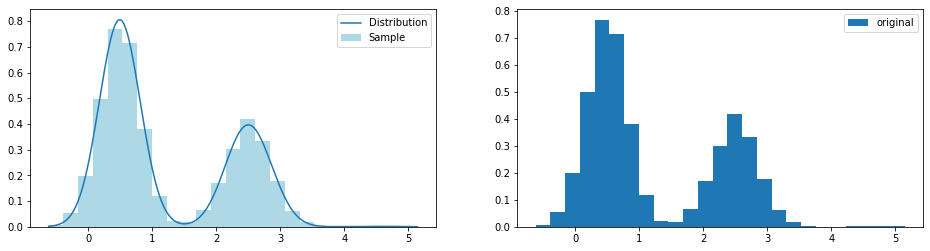

In [8]:
xrand_post, original_r_post, x_post, y_post, _ = get_values()
        
plt.subplot(1,2,1)
plt.hist(xrand_post[:,d], bins=25, density=True, color="lightblue", label="Sample")
plt.plot(x_post, y_post, label="Distribution")
_ = plt.legend()
plt.subplot(1,2,2)
plt.hist(original_r_post[:,d], bins=25, density=True, label="original")
_ = plt.legend()

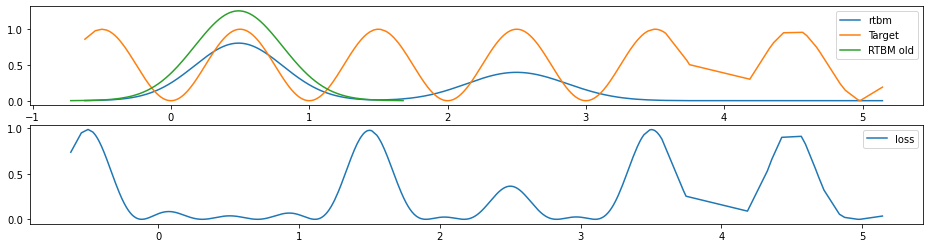

In [9]:
my_y_post = my_fun(x_post)
ll_post = loss(my_y_post, y_post)


plt.subplot(2,1,1)
plt.plot(x_post, y_post, label="rtbm")
plt.plot(x_post, my_y_post, label = "Target")
plt.plot(x, y, label="RTBM old")
_ = plt.legend()
plt.subplot(2,1,2)
plt.plot(x_post, ll_post, label="loss")
_ = plt.legend()

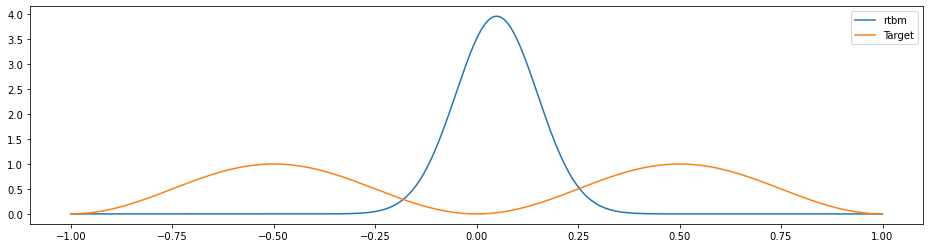

In [10]:
do_uniform = True
rtbm.set_parameters(params_0)
if do_uniform:
    original_x_uniform = np.array(sorted(-1.0 + 2.0*np.random.rand(int(nevt),1)))
    x_uniform, y_uniform = rtbm.get_transformation(original_x_uniform)
    my_uniform = my_fun(x_uniform)

    plt.plot(x_uniform, y_uniform, label="rtbm")
    plt.plot(x_uniform, my_uniform, label = "Target")
    _ = plt.legend()

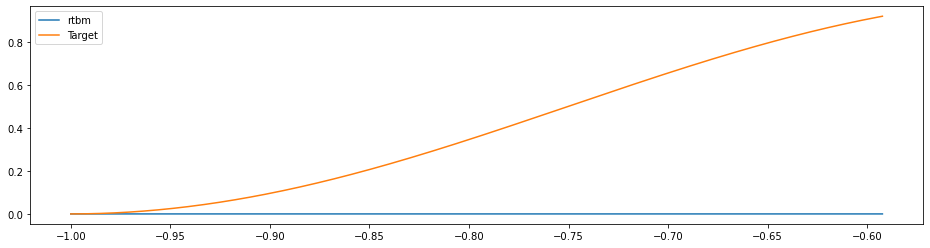

In [11]:
if do_uniform:
    batches = 5
    n_per_batch = int(len(original_x_uniform)/batches)
    
    i = 0
    
    xb = x_uniform[i*n_per_batch:(i+1)*n_per_batch]
    yb = y_uniform[i*n_per_batch:(i+1)*n_per_batch]
    myb = my_uniform[i*n_per_batch:(i+1)*n_per_batch]

    plt.plot(xb, yb, label="rtbm")
    plt.plot(xb, myb, label = "Target")
    _ = plt.legend()

In [12]:
if do_uniform:
    rtbm.set_parameters(params_0)
    for _ in range(15):
        options = {
            "bounds": bounds,
            "maxiter": 40,
            "tolfun": 1e-4,
            "popsize": 120,
            "verbose": 0,
        }
        initial_state = copy.deepcopy(rtbm.get_parameters())
        es = CMAEvolutionStrategy(initial_state, sigma, options)
        
        i = np.random.randint(batches)
        xx = original_x_uniform[i*n_per_batch:(i+1)*n_per_batch]
        yy = my_uniform[i*n_per_batch:(i+1)*n_per_batch]

        def target_loss(params):
            if not rtbm.set_parameters(params):
                return np.NaN
                #import ipdb; ipdb.set_trace()
            _, prob = rtbm.get_transformation(xx)
            return np.sum(loss(prob, yy))
        
        
        with Parallel(n_jobs=4) as parallel:
            while not es.stop():
                mutants = es.ask(es.popsize)
                # Parallelize this
                # losses = [target_loss(i) for i in mutants]
                parallel_runs = [delayed(target_loss)(i) for i in mutants]
                losses = parallel(parallel_runs)
                worst = np.nanmax(losses)
                if np.isnan(worst):
                    continue
                losses = [2.0*worst if np.isnan(x) else x for x in losses]
                es.tell(mutants, losses)
                es.disp()

        es.optimize(target_loss)
        
        _ = rtbm.set_parameters(es.result.xbest)
    best_uniform_parameters = copy.deepcopy(rtbm.get_parameters())

(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=871716, Wed Mar  3 09:13:34 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 3.998169332148215e+05 1.0e+00 6.05e+00  6e+00  7e+00 0:01.3
    2    240 3.650890497443244e+05 1.4e+00 6.62e+00  6e+00  8e+00 0:02.3
    3    360 4.029059703270275e+05 1.7e+00 7.28e+00  6e+00  8e+00 0:03.3
    7    840 4.177172595648440e+05 2.2e+00 6.70e+00  4e+00  8e+00 0:07.3
   11   1320 4.033733811706633e+05 2.9e+00 6.32e+00  3e+00  7e+00 0:11.3
   16   1920 3.639665862626776e+05 3.1e+00 5.06e+00  2e+00  5e+00 0:16.6
   21   2520 3.629317031423564e+05 5.2e+00 4.09e+00  6e-01  3e+00 0:22.7
   27   3240 3.635675599689787e+05 1.0e+01 3.39e+00  3e-01  3e+00 0:30.3
   33   3960 3.629222670246094e+05 1.8e+01 2.83e+00  1e-01  2e+00 0:39.3
   39   4680 3.629022637777418e+05 6.8e+01 3.11e+00  3e-02  3e+00 0:48.5
   40   4800 3.629000066410598e+05 8.9e+01 3.00e+00  3e-02  3e+00 0:50.0
   41   4920 3.628946974293162e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [1, 8, 13, 19, 20, 27, 34, 37, 44, 47, 51, 56, 66, 67, 81, 82, 87, 94, 96, 101, 118]/[] are nan/None and will be set to the median value 54577.37698229452 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=956394, Wed Mar  3 09:17:22 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 1.760001590423807e+05 1.0e+00 4.91e+00  4e+00  5e+00 0:01.0
    2    240 1.682512060378192e+05 1.4e+00 4.80e+00  4e+00  5e+00 0:01.9
    3    360 2.306582324325158e+05 1.6e+00 4.90e+00  3e+00  5e+00 0:03.2
    6    720 1.646466710857681e+05 2.2e+00 4.98e+00  2e+00  5e+00 0:06.7
   10   1200 1.680405742341206e+05 3.1e+00 5.36e+00  2e+00  5e+00 0:11.6
   14   1680 1.691286778835754e+05 5.6e+00 5.11e+00  1e+00  5e+00 0:16.7
   19   2280 1.612730810645729e+05 7.4e+00 3.99e+00  6e-01  4e+00 0:22.9
   25   3000 1.600214884967634e+05 9.4e+00 3.95e+00  4e-01  3e+00 0:30.6
   32   3840 1.593565554524139e+05 1.2e+01 3.39e+00  3e-01  3e+00 0:40.0
   38   4560 1.578233113559196e+05 2.5e+01 2.76e+00  8e-02  2e+00 0:50.1
   40   4800 1.578326373155342e+05 5.1e+01 2.76e+00  4e-02  3e+00 0:53.3
   41   4920 1.578211167070006e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [1, 3, 8, 12, 16, 18, 20, 26, 42, 52, 62, 73, 80, 82, 90, 91, 93, 95, 102, 103, 114, 116]/[] are nan/None and will be set to the median value 390090.52642225235 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=841248, Wed Mar  3 09:20:12 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 1.930568744617231e+05 1.0e+00 5.34e+00  5e+00  6e+00 0:01.0
    2    240 1.913614788895047e+05 1.4e+00 5.20e+00  4e+00  5e+00 0:02.0
    3    360 1.600458711982525e+05 1.5e+00 5.05e+00  4e+00  5e+00 0:03.3
    6    720 2.007007032946312e+05 2.2e+00 4.84e+00  3e+00  5e+00 0:06.8
   10   1200 1.846964707148374e+05 3.9e+00 4.39e+00  2e+00  5e+00 0:11.7
   15   1800 1.597117893867627e+05 6.4e+00 4.75e+00  1e+00  5e+00 0:17.9
   20   2400 1.581644133269974e+05 8.6e+00 4.13e+00  6e-01  5e+00 0:24.2
   25   3000 1.624103035054412e+05 1.3e+01 4.65e+00  5e-01  5e+00 0:31.5
   31   3720 1.588079129429267e+05 1.9e+01 4.25e+00  4e-01  5e+00 0:41.3
   37   4440 1.587370222157315e+05 2.0e+01 3.31e+00  3e-01  3e+00 0:50.7
   40   4800 1.579199419780175e+05 2.3e+01 3.07e+00  3e-01  3e+00 0:55.6
   41   4920 1.584004097739322e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [1, 2, 6, 18, 23, 26, 33, 39, 41, 45, 51, 62, 85, 98, 99, 100, 113, 118]/[] are nan/None and will be set to the median value 388572.8814394948 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


   41   4920 3.419553604192818e+05 1.9e+01 4.05e+00  2e-01  2e+00 1:00.8
(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=879097, Wed Mar  3 09:22:13 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 4.099232956446176e+05 1.0e+00 4.90e+00  4e+00  5e+00 0:01.2
    2    240 4.049599716871234e+05 1.4e+00 5.24e+00  4e+00  6e+00 0:02.5
    3    360 4.394896637413903e+05 1.6e+00 5.50e+00  4e+00  6e+00 0:03.5
    6    720 3.639484207190066e+05 2.2e+00 5.08e+00  3e+00  5e+00 0:06.9
    9   1080 3.652587588847220e+05 2.3e+00 5.55e+00  3e+00  5e+00 0:11.3
   13   1560 3.656242761393270e+05 2.8e+00 5.77e+00  2e+00  6e+00 0:16.6
   18   2160 3.634311530990182e+05 4.8e+00 5.42e+00  1e+00  5e+00 0:23.2
   23   2760 3.662597008444530e+05 7.9e+00 4.76e+00  5e-01  4e+00 0:30.5
   29   3480 3.631359814540251e+05 1.5e+01 4.69e+00  3e-01  4e+00 0:39.1
   35   4200 3.630683305683119e+05 2.4e+01 5.90e+00  3e-01  5e+00 0:48.3
   40   4800 3.629084588311475e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [0, 1, 11, 19, 31, 39, 43, 51, 63, 96, 101, 107]/[] are nan/None and will be set to the median value 404699.8658784968 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=856427, Wed Mar  3 09:23:12 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 4.827644093679407e+05 1.0e+00 4.77e+00  4e+00  5e+00 0:00.9
    2    240 4.070611018564146e+05 1.4e+00 4.68e+00  3e+00  5e+00 0:01.9
    3    360 3.753269312488371e+05 1.6e+00 4.40e+00  3e+00  5e+00 0:03.0
    6    720 3.717433160070257e+05 2.2e+00 4.40e+00  2e+00  4e+00 0:07.0
   10   1200 3.649575336503196e+05 2.5e+00 3.88e+00  2e+00  3e+00 0:12.5
   14   1680 3.651403618125866e+05 3.6e+00 3.70e+00  1e+00  3e+00 0:18.1
   19   2280 3.643535405099663e+05 5.9e+00 3.49e+00  5e-01  3e+00 0:25.5
   24   2880 3.635301533331418e+05 8.4e+00 3.57e+00  4e-01  3e+00 0:32.7
   30   3600 3.636436001313984e+05 1.7e+01 2.94e+00  2e-01  3e+00 0:41.8
   37   4440 3.632076132032209e+05 2.6e+01 2.53e+00  1e-01  2e+00 0:51.7
   40   4800 3.631965092545130e+05 3.0e+01 2.25e+00  8e-02  2e+00 0:56.0
   41   4920 3.636747179574212e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [16, 27, 86, 88, 100]/[] are nan/None and will be set to the median value 387839.84457192605 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=894340, Wed Mar  3 09:24:12 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 1.754153993616411e+05 1.0e+00 4.68e+00  4e+00  5e+00 0:00.8
    2    240 4.211719123550765e+05 1.5e+00 5.07e+00  4e+00  6e+00 0:01.8
    3    360 3.269753629251153e+05 1.9e+00 4.91e+00  3e+00  6e+00 0:03.0
    6    720 1.711218528022158e+05 2.2e+00 4.51e+00  2e+00  5e+00 0:06.5
   10   1200 1.923991731135973e+05 3.0e+00 3.70e+00  1e+00  4e+00 0:11.9
   14   1680 1.666805805415978e+05 4.4e+00 4.39e+00  1e+00  4e+00 0:17.8
   19   2280 1.638787915106672e+05 5.6e+00 4.17e+00  7e-01  4e+00 0:24.5
   24   2880 1.664393591819918e+05 8.4e+00 4.33e+00  5e-01  3e+00 0:31.9
   29   3480 1.651565726791552e+05 1.3e+01 3.86e+00  3e-01  3e+00 0:39.9
   36   4320 1.641818361436366e+05 1.8e+01 3.84e+00  2e-01  3e+00 0:50.3
   40   4800 1.642128269472637e+05 1.7e+01 4.50e+00  3e-01  3e+00 0:55.7
   41   4920 1.666359736784832e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [4, 5, 9, 13, 18, 20, 21, 28, 35, 41, 44, 60, 87, 102]/[] are nan/None and will be set to the median value 874156.9806467697 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=806479, Wed Mar  3 09:25:12 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 6.894186514581107e+04 1.0e+00 4.93e+00  5e+00  5e+00 0:00.8
    2    240 4.752320062579984e+04 1.4e+00 4.89e+00  4e+00  5e+00 0:01.8
    3    360 7.310494243872815e+04 1.6e+00 4.76e+00  4e+00  5e+00 0:02.9
    6    720 7.389029159737639e+04 2.3e+00 5.11e+00  4e+00  6e+00 0:06.1
   10   1200 4.713681764984576e+04 2.9e+00 4.60e+00  3e+00  5e+00 0:11.1
   14   1680 5.040821636656306e+04 3.5e+00 4.27e+00  2e+00  4e+00 0:16.5
   18   2160 4.860835447300277e+04 5.9e+00 3.57e+00  1e+00  4e+00 0:22.6
   23   2760 4.899757226261423e+04 1.5e+01 3.71e+00  8e-01  5e+00 0:31.0
   29   3480 4.718103890429509e+04 3.7e+01 3.45e+00  5e-01  4e+00 0:40.7
   35   4200 4.707641339042864e+04 8.0e+01 3.81e+00  3e-01  4e+00 0:50.3
   40   4800 4.674540999393199e+04 1.4e+02 3.97e+00  2e-01  3e+00 0:58.8
   41   4920 4.679944645545114e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [2, 11, 14, 18, 46, 64, 78, 87, 99, 103]/[] are nan/None and will be set to the median value 47748.28017936584 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=781830, Wed Mar  3 09:26:15 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 2.051946090695722e+05 1.0e+00 4.75e+00  4e+00  5e+00 0:01.1
    2    240 2.069667962758466e+05 1.3e+00 4.70e+00  4e+00  5e+00 0:02.2
    3    360 2.256268472240397e+05 1.4e+00 4.88e+00  3e+00  5e+00 0:03.4
    6    720 1.861083953630549e+05 2.0e+00 4.70e+00  3e+00  5e+00 0:07.4
   10   1200 1.680176552117110e+05 2.8e+00 3.99e+00  1e+00  5e+00 0:12.7
   14   1680 1.626466971954034e+05 4.7e+00 3.99e+00  1e+00  5e+00 0:18.7
   19   2280 1.626429880535280e+05 7.6e+00 3.67e+00  6e-01  4e+00 0:25.7
   24   2880 1.586437985163636e+05 9.1e+00 3.18e+00  4e-01  3e+00 0:33.2
   29   3480 1.583592807988510e+05 1.4e+01 3.21e+00  4e-01  4e+00 0:41.3
   35   4200 1.580910502278122e+05 1.5e+01 3.42e+00  4e-01  4e+00 0:50.4
   40   4800 1.583903002931256e+05 1.5e+01 3.61e+00  4e-01  3e+00 0:57.4
   41   4920 1.578732061902013e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [10, 29, 34, 43, 47, 61, 69, 80, 96, 103, 107, 116]/[] are nan/None and will be set to the median value 646684.3215507618 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


(60_w,120)-aCMA-ES (mu_w=32.1,w_1=7%) in dimension 9 (seed=845487, Wed Mar  3 09:27:17 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    120 2.655724646818860e+05 1.0e+00 4.85e+00  4e+00  5e+00 0:01.1
    2    240 3.383128331234454e+05 1.3e+00 4.43e+00  4e+00  4e+00 0:02.0
    3    360 2.271106502649398e+05 1.4e+00 4.69e+00  4e+00  5e+00 0:03.3
    5    600 1.687832725545532e+05 1.9e+00 4.50e+00  3e+00  5e+00 0:06.7
    9   1080 1.716769246300702e+05 2.9e+00 4.30e+00  2e+00  5e+00 0:11.9
   13   1560 1.865493813229382e+05 3.9e+00 4.47e+00  1e+00  5e+00 0:17.3
   18   2160 1.654023804294411e+05 6.3e+00 3.66e+00  7e-01  3e+00 0:24.4
   23   2760 1.674507666538311e+05 7.9e+00 3.43e+00  6e-01  3e+00 0:32.2
   29   3480 1.652155934036587e+05 1.1e+01 2.92e+00  4e-01  2e+00 0:41.2
   36   4320 1.633252218061522e+05 1.2e+01 2.95e+00  3e-01  2e+00 0:50.6
   40   4800 1.632903381733204e+05 1.4e+01 2.91e+00  3e-01  3e+00 0:56.4
   41   4920 1.636440026015432e+

/home/jumax9/Academic_Workspace/N3PDF/VegasFlow/vflow/lib/python3.9/site-packages/cma/utilities/utils.py:343: UserWarning: function values with index [0, 6, 17, 19, 53, 55, 59, 63, 67, 79, 84, 87, 89, 92, 99, 110, 116]/[] are nan/None and will be set to the median value 593697.9164472328 (class=CMAEvolutionStrategy method=ask iteration=40)
  warnings.warn(msg + ' (' +


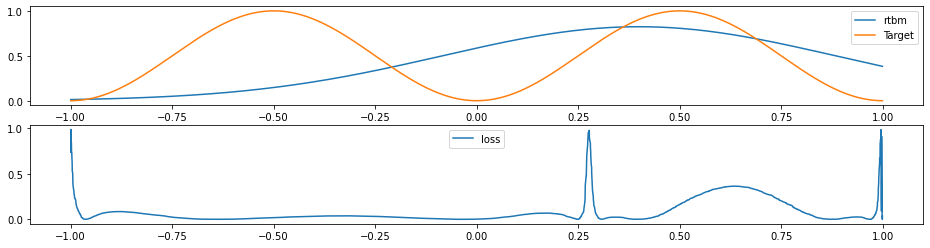

In [13]:
if do_uniform:
    original_x_uniform = np.array(sorted(-1.0 + 2.0*np.random.rand(int(nevt),1)))
    x_uniform, y_uniform = rtbm.get_transformation(original_x_uniform)
    my_uniform = my_fun(x_uniform)
    ll_uniform = loss(y_uniform, my_uniform) 

    plt.subplot(2,1,1)
    plt.plot(x_uniform, y_uniform, label="rtbm")
    plt.plot(x_uniform, my_uniform, label = "Target")
    _ = plt.legend()
    plt.subplot(2,1,2)
    plt.plot(x_uniform, ll_post, label="loss")
    _ = plt.legend()